In [2]:
from typing import List
import numpy as np
import scipy.special as sp_spec
import scipy.stats as sp_stats
import numpy.random as np_rand
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import seaborn as sns
import tqdm

# Bernoulli Mixture Model
See the solution pdf for derivation of CAVI updates, ELBO and for notation used throughout the notebook. See theory part of Exercise problems for algorithm psuedo code and more. Updates are written using for-loops to more clearly show relation to derivations, however, you are recommended to use matrix operations.


### Generate data

In [3]:
def generate_data_and_priors(N: int, D: int, K: int, theta_a: float, theta_b: float, pi_alpha: List[int]):
  """
  Generates datapoints and hidden variables given parameters for the priors.
  :param N: Number of datapoints
  :param D: Data dimension.
  :param K: Number of mixture components.
  :param theta_a: "a" parameter of the Beta(a,b) prior on theta.
  :param theta_b: "b" parameter of the Beta(a,b) prior on theta.
  :param pi_alpha: parameter of the Dirichlet(alpha) prior on pi.
  :return:
  """
  theta = np_rand.beta(theta_a, theta_b, size=(K,D))  # K x D matrix
  pi = np_rand.dirichlet(pi_alpha) # size K array
  x = np.zeros((N,D)) # N x D matrix
  z = np.zeros(N)     # size N array 
  for n in range(N):
    z_n = np_rand.multinomial(1, pi).argmax() # for each datapoint n, sample the component assignment/class variable
    x_n = np.zeros(D)
    for d in range(D): 
      x_n[d] = np_rand.binomial(1, theta[z_n, d]) # Sample x_nd from Bernoulli(theta_kd)
    z[n] = z_n
    x[n, :] = x_n

  return x, z, theta, pi

def generate_data(N: int, D: int, K: int, theta: np.ndarray , pi: np.ndarray):
  """
   Generates datapoints given values of the hidden variables. Can be used for more "control" of experiments.
  :param N: Number of datapoints
  :param D: Data dimension.
  :param K: Number of mixture components.
  :param theta: Values of theta.
  :param pi: Value of pi.
  :return:
  """
  x = np.zeros((N,D)) # N x D matrix
  z = np.zeros(N)     # size N array
  for n in range(N):
    z_n = np_rand.multinomial(1, pi).argmax() # for each datapoint n, sample the component assignment/class variable
    x_n = np.zeros(D)
    for d in range(D):
      x_n[d] = np_rand.binomial(1, theta[z_n, d])
    z[n] = z_n
    x[n, :] = x_n

  return x, z, theta, pi

# Test the functions by running for some simple cases and verify that data and variables look as expected.
N = 1000
D = 3
K = 2

theta = np.array([[0.1, 0.7, 0.2], [0.6, 0.2, 0.2]])
pi = np.array([0.4, 0.6])
x, z, theta, pi = generate_data(N, D, K, theta, pi)
print(f"First 3 datapoints: {x[0:3, 0:5]}")
print(f"First 3 z: {z[0:3]}")

x_mean = np.mean(x, axis=0)
print(f"Mean of x: {x_mean}")
print(f"Expected x: {pi[0] * theta[0] + pi[1] * theta[1]}")
z_one_hot = np.eye(K)[z.astype(int)]
print(f"Mean of z: {np.mean(z_one_hot, axis=0)}")
print(f"Expected z: {pi}")

First 3 datapoints: [[1. 0. 0.]
 [1. 1. 1.]
 [0. 0. 0.]]
First 3 z: [1. 1. 1.]
Mean of x: [0.425 0.382 0.196]
Expected x: [0.4 0.4 0.2]
Mean of z: [0.395 0.605]
Expected z: [0.4 0.6]


# CAVI Algorithm

## CAVI updates

### $q(\theta)$ update

In [4]:
def update_q_theta(x, r_q, a_prior, b_prior):
    E_Z = r_q
    N, D = x.shape
    K = r_q.shape[1]

    # With Einsum
    a_star = np.einsum('nk,nd->kd', E_Z, x) + a_prior
    b_star = np.einsum('nk,nd->kd', E_Z, 1 - x) + b_prior

    # Without Einsum
    # a_star = np.zeros((K, D))
    # b_star = np.zeros((K, D))
    # for k in range(K):
    #     for d in range(D):
    #         a_kd = np.sum(r_q[:,k] * x[:,d]) + a_prior
    #         b_kd = np.sum(r_q[:,k] * (1 - x[:, d])) + b_prior
    #         a_star[k, d] = a_kd
    #         b_star[k, d] = b_kd

    return a_star, b_star

### $q(Z)$ update


In [5]:
def update_q_Z(x, a_q, b_q, alpha_q):
    """
    Implements the CAVI update equation of q(Z) derived in the solution of the exercise.
    """
    E_log_theta = sp_spec.digamma(a_q) - sp_spec.digamma(a_q + b_q)         # K x D
    E_log_1_minus_theta = sp_spec.digamma(b_q) - sp_spec.digamma(a_q + b_q) # K x D
    E_log_pi = sp_spec.digamma(alpha_q) - sp_spec.digamma(np.sum(alpha_q))  # K array

    log_rho = (np.einsum('nd,kd->nk', x, E_log_theta)
               + np.einsum('nd,kd->nk', 1 - x, E_log_1_minus_theta)
               + E_log_pi)

    r_star = np.exp(log_rho - sp_spec.logsumexp(log_rho, axis=1, keepdims=True))
    return r_star

### $q(\pi)$ update

In [6]:
def update_q_pi(E_Z, alpha_prior):
    alpha_star = np.sum(E_Z, axis=0) + alpha_prior  # size K array
    return alpha_star

## ELBO

In [7]:
def multivariate_beta_function(a):
    eps = 0.0001  # for numerical stability to avoid -inf
    return np.exp(np.sum(sp_spec.gammaln(a + eps) - sp_spec.gammaln(np.sum(a + eps))))

def calculate_elbo(x, r_q, a_q, b_q, alpha_q):
    N, D = x.shape
    K = r_q.shape[1]
    E_log_theta = sp_spec.digamma(a_q) - sp_spec.digamma(a_q + b_q)
    E_log_1_minus_theta = sp_spec.digamma(b_q) - sp_spec.digamma(a_q + b_q)
    E_log_pi = sp_spec.digamma(alpha_q) - sp_spec.digamma(np.sum(alpha_q))
    alpha_0 = np.sum(alpha_q)
    CR_likelihood = np.sum(r_q * (np.einsum('nd,kd->nk', x, E_log_theta)
                                  + np.einsum('nd,kd->nk', 1 - x, E_log_1_minus_theta)))
    CR_Z = np.sum(r_q * E_log_pi)
    eps = 0.0001  # for numerical stability to avoid -inf
    CR_pi = -np.log(multivariate_beta_function(alpha_q) + eps) + np.sum((alpha_q - 1) * E_log_pi)
    CR_theta = np.sum((a_q-1) * E_log_theta + (b_q-1) * E_log_1_minus_theta - sp_spec.beta(a_q, b_q))
    H_Z = np.sum(r_q * np.log(r_q + eps))
    H_pi = np.log(multivariate_beta_function(alpha_q) + eps) + (alpha_0 - K) * sp_spec.digamma(alpha_0) - \
           np.sum((alpha_q - 1) * sp_spec.digamma(alpha_q))
    Beta_ab = sp_spec.beta(a_q, b_q) + eps
    H_theta = np.sum(np.log(Beta_ab) - (a_q - 1) * sp_spec.digamma(a_q) -
                     (b_q - 1) * sp_spec.digamma(b_q) + (a_q + b_q + 2) * sp_spec.digamma(a_q + b_q))
    elbo = CR_likelihood + CR_Z + CR_pi + CR_theta + H_Z + H_pi + H_theta
    return elbo

## Initialization

In [8]:
def initialize_q(x, K):
    #r_q_init = np.random.random((N,K))
    N, D = x.shape
    kmeans =  KMeans(n_clusters=K, random_state=0, n_init=30).fit(x)
    labels = kmeans.labels_
    a_q_init = np.zeros((K, D))
    b_q_init = np.zeros((K, D))
    for k in range(K):
        x_k = x[labels == k]
        a_q_init[k, :] = np.mean(x_k, axis=0) + 1
        b_q_init[k, :] = np.mean(1 - x_k, axis=0) + 1

    r_q_init = np.random.rand(N, K)
    r_q_init = r_q_init / np.sum(r_q_init, axis=1, keepdims=True)  # normalize
    #a_q_init = np.random.randint(1, 100, size=(K,D))
    #b_q_init = np.random.randint(1, 100, size=(K,D))
    alpha_q_init = np.ones(K)
    return r_q_init, a_q_init, b_q_init, alpha_q_init

## CAVI algorithm

In [9]:
def CAVI_algorithm(x, K, n_iter, a_prior, b_prior, alpha_prior, step_size=0.01, tol=1e-6):
    N, D = x.shape

    r_q, a_q, b_q, alpha_q = initialize_q(x, K)
    elbo_after_init = calculate_elbo(x, r_q, a_q, b_q, alpha_q)
    # Store output per iteration
    elbo = [elbo_after_init]
    r_q_out = [r_q]
    a_q_out = [a_q]
    b_q_out = [b_q]
    alpha_q_out = [alpha_q]

    pbar = tqdm.tqdm(range(n_iter))
    for i in pbar:
        # CAVI updates
        # q(Z) update
        r_star = update_q_Z(x, a_q, b_q, alpha_q)
        r_q += step_size * (r_star - r_q)
        r_q = r_q / np.sum(r_q, axis=1, keepdims=True)  # normalize

        # q(pi) update
        alpha_star = update_q_pi(r_q, alpha_prior)
        alpha_q += step_size * (alpha_star - alpha_q)

        # q(theta) update
        a_star, b_star = update_q_theta(x, r_q, a_prior, b_prior)
        a_q = a_q + step_size * (a_star - a_q)
        b_q = b_q + step_size * (b_star - b_q)

        # ELBO
        elbo.append(calculate_elbo(x, r_q, a_q, b_q, alpha_q))

        # outputs
        r_q_out.append(r_q)
        a_q_out.append(a_q)
        b_q_out.append(b_q)
        alpha_q_out.append(alpha_q)

        pbar.set_description(f"ELBO: {elbo[i]:.2f}")

        if i > 1 and np.abs(elbo[i] - elbo[i-1]) < tol:
            break

    r_q_out = np.array(r_q_out)
    a_q_out = np.array(a_q_out)
    b_q_out = np.array(b_q_out)
    alpha_q_out = np.array(alpha_q_out)
    elbo = np.array(elbo)
    out = {"r_q": r_q_out, "a_q": a_q_out, "b_q": b_q_out, "alpha_q": alpha_q_out, "elbo": elbo}
    return out

## Run optimization on simulated data

In [14]:
N = 1000
D = 100
K = 5
n_iter = 3000
a_prior = 1.
b_prior = 1.
alpha_prior = np.ones(K) * 1.0
# theta = np.array([[0.1, 0.9, 0.0, 0.0], [0.0, 0.05, 0.45, 0.5]])
# pi = np.array([0.6, 0.4])
# x, z, theta, pi = generate_data(N, D, K, theta, pi)
x, z, theta, pi = generate_data_and_priors(N, D, K, a_prior, b_prior, alpha_prior)
out = CAVI_algorithm(x, K, n_iter, a_prior, b_prior, alpha_prior)
r_q_out = out["r_q"]
a_q_out = out["a_q"]
b_q_out = out["b_q"]
alpha_q_out = out["alpha_q"]
elbo = out["elbo"]
np.printoptions(precision=2)
print(f"Print results (check for label switching).")
print(f"z :{z[0:10]}")
# As q(Z) is our variational posterior and is a Categorical, argmax corresponds to our MAP estimates
MAP_assignments = r_q_out[-1].argmax(axis=1)
print(f"r_q :{MAP_assignments[0:10]}")
print(f"ARI :{adjusted_rand_score(z, MAP_assignments)}")  # clustering metric that is independent of label switching

print(f"Expected value pi: {alpha_q_out[-1] / np.sum(alpha_q_out[-1])}")
print(f"True pi: {pi}")

ELBO: -46079.35:  95%|█████████▌| 2863/3000 [00:03<00:00, 718.99it/s]


Print results (check for label switching).
z :[1. 4. 1. 1. 3. 1. 4. 4. 3. 1.]
r_q :[1 3 1 1 2 1 3 3 2 1]
ARI :0.9814452372000219
Expected value pi: [0.00199005 0.57711443 0.12437683 0.17711443 0.11940426]
True pi: [0.11992906 0.5804614  0.05860275 0.06571685 0.17528994]


Text(0, 0.5, 'ELBO')

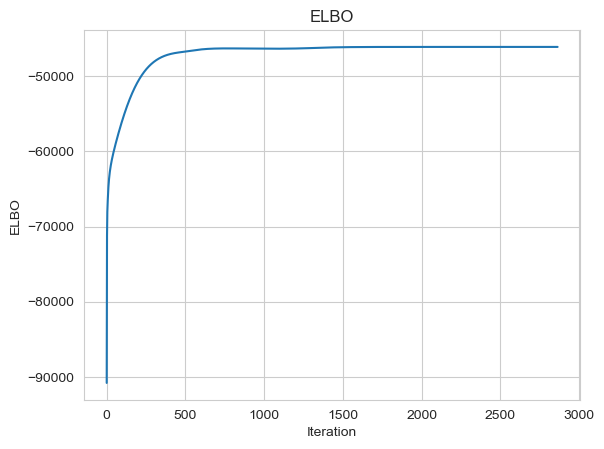

In [15]:
elbo = out["elbo"]
plt.plot(elbo)
plt.title("ELBO")
plt.xlabel("Iteration")
plt.ylabel("ELBO")

#### Visualize optimization

Plots the parameters of $q(\theta_{kd})$ for a particular k and d, plotted for different iterations.

The corresponding Beta distribution is also plotted for the same parameters.

This is to illustrate when we are updating the parameters during the CAVI optimization, we are implicitly updating the optimal $q(\theta_{dk})$ distribution that we derived on the board.  

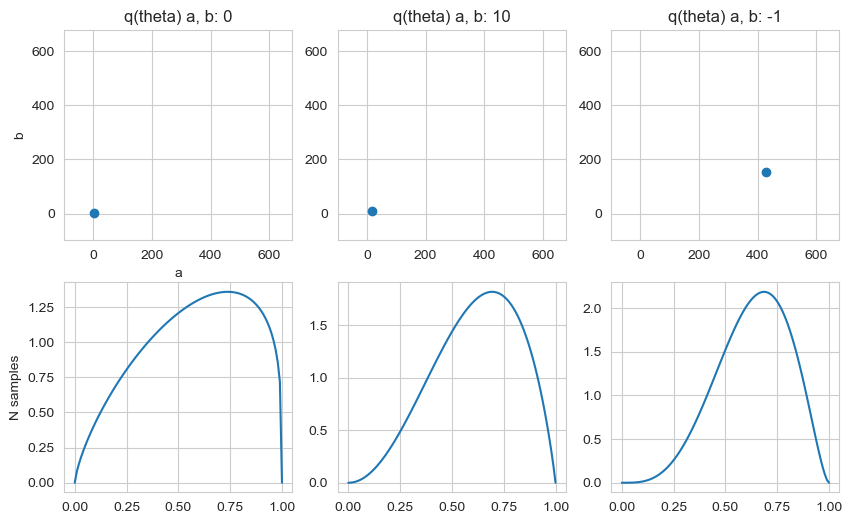

In [18]:
xlim_a_min = a_q_out.min()
xlim_a_max = a_q_out.max()
ylim_b_min = b_q_out.min()
ylim_b_max = b_q_out.max()
iterations_to_plot = [0, 10, -1]
n_iter_to_plot = len(iterations_to_plot)
fig, axs = plt.subplots(2, n_iter_to_plot, figsize=(10, 6))
d_to_plot = 0  # a_kd
k_to_plot = 1
for i in range(0, n_iter_to_plot):
    j = iterations_to_plot[i]
    axs[0, i].scatter(a_q_out[j, k_to_plot, d_to_plot], b_q_out[j, k_to_plot, d_to_plot])
    axs[0, i].set_title(f"q(theta) a, b: {j}")
    axs[0, i].set_xlim(int(xlim_a_min) - 100, int(xlim_a_max) + 100)
    axs[0, i].set_ylim(int(ylim_b_min) - 100, int(ylim_b_max) + 100)

    q_theta_kd = sp_stats.beta(a_q_out[i, k_to_plot, d_to_plot], b_q_out[i, k_to_plot, d_to_plot])
    pi_axis = np.linspace(0, 1, 100)
    axs[1, i].plot(pi_axis, q_theta_kd.pdf(pi_axis))

    if i == 0:
        axs[0, i].set_xlabel('a')
        axs[0, i].set_ylabel('b')
        axs[1, i].set_ylabel('N samples')

plt.show()

## Run on MNIST data

In [19]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
X = mnist.data
y = mnist.target
X = X.to_numpy()

selected_digits = [0, 1, 2, 3, 4]
train_filter = []
N_k = [1000, 1000, 1000, 1000, 1000]
for k,s in enumerate(selected_digits):
    train_filter.append(np.where(y == str(s))[0][0:N_k[k]])

train_filter = np.concatenate(train_filter)
X = X[train_filter, :]
y = y[train_filter]
N = len(train_filter)
X = X[0:N, :]
X = (X > 127.5).astype(int)  # binarize

In [20]:
N, D = X.shape
K = len(selected_digits)
n_iter = 500
a_prior = 1.
b_prior = 1.
alpha_prior = np.ones(K) * N/K

print(f"Priors: {alpha_prior}")
print(f"Number of iterations: {n_iter}")
print(f"Number of datapoints: {N}")
out = CAVI_algorithm(X, K, n_iter,
                     a_prior, b_prior, alpha_prior,
                     step_size=0.1)

Priors: [1000. 1000. 1000. 1000. 1000.]
Number of iterations: 500
Number of datapoints: 5000


ELBO: -770590.22: 100%|██████████| 500/500 [01:04<00:00,  7.79it/s]


Text(0, 0.5, 'ELBO')

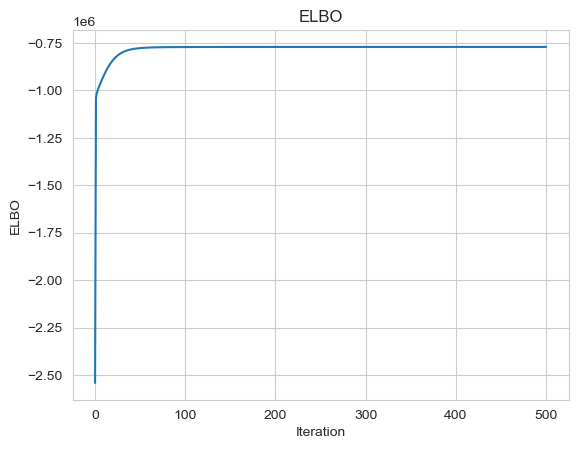

In [21]:
elbo = out["elbo"]
plt.plot(elbo)
plt.title("ELBO")
plt.xlabel("Iteration")
plt.ylabel("ELBO")

In [25]:

r_q_out = out["r_q"]
a_q_out = out["a_q"]
b_q_out = out["b_q"]
alpha_q_out = out["alpha_q"]
elbo = out["elbo"]
np.printoptions(precision=2)

sklearn_kmeans = KMeans(n_clusters=K, random_state=0, n_init=30).fit(X)
labels = sklearn_kmeans.labels_
print(f"ARI KMeans:{adjusted_rand_score(y[0:N], labels)}")  # clustering metric that is independent of label switching

MAP_assignments = r_q_out[-1].argmax(axis=1)
print(f"ARI CAVI:{adjusted_rand_score(y[0:N], MAP_assignments)}")

y_labels, y_counts = np.unique(y[0:N], return_counts=True)
print(f"True pi: {y_counts / np.sum(y_counts)}")
print(f"Expected value pi: {alpha_q_out[-1] / np.sum(alpha_q_out[-1])}")

ARI KMeans:0.7011475602523373
ARI CAVI:0.7701012234646323
True pi: [0.2 0.2 0.2 0.2 0.2]
Expected value pi: [0.1927237  0.20298914 0.20607211 0.19115799 0.20705706]


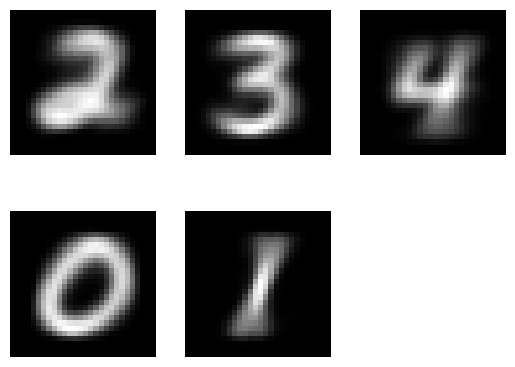

In [26]:
for k in range(K):
    plt.subplot(2, int(K/2) + (K % 2), k + 1)
    E_theta_k = a_q_out[-1][k] / (a_q_out[-1][k] + b_q_out[-1][k])
    plt.imshow(E_theta_k.reshape(28, 28), cmap="gray")
    plt.axis("off")

Probability of most uncertain sample of cluster 0: [0.53 0.47 0.00 0.00 0.00]
Probability of most certain sample of cluster 0: [1.00 0.00 0.00 0.00 0.00]
Probability of most uncertain sample of cluster 1: [0.04 0.73 0.00 0.00 0.23]
Probability of most certain sample of cluster 1: [0.00 1.00 0.00 0.00 0.00]
Probability of most uncertain sample of cluster 2: [0.00 0.00 0.57 0.00 0.43]
Probability of most certain sample of cluster 2: [0.00 0.00 1.00 0.00 0.00]
Probability of most uncertain sample of cluster 3: [0.00 0.47 0.00 0.53 0.00]
Probability of most certain sample of cluster 3: [0.00 0.00 0.00 1.00 0.00]
Probability of most uncertain sample of cluster 4: [0.00 0.06 0.28 0.00 0.66]
Probability of most certain sample of cluster 4: [0.00 0.00 0.00 0.00 1.00]


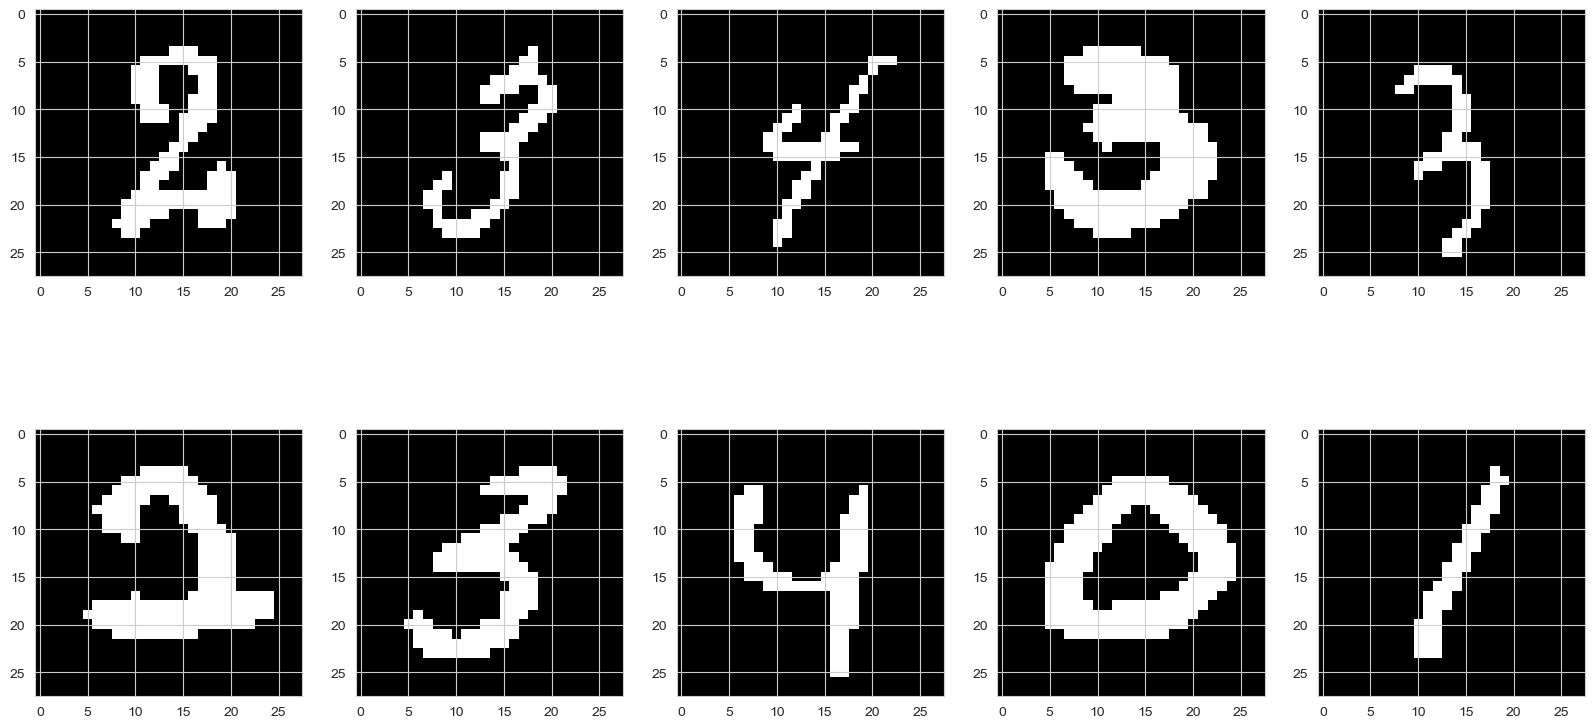

In [34]:
# Plot most certain vs uncertain images
fig, axs = plt.subplots(2, K, figsize=(20, 10))
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
for k in range(K):
    idx_qZ_k = np.where(MAP_assignments==k)[0]
    max_entropy_idx = np.argmax(sp_stats.entropy(r_q_out[-1][idx_qZ_k], axis=1))
    print(f"Probability of most uncertain sample of cluster {k}: {r_q_out[-1][idx_qZ_k][max_entropy_idx]}")
    min_entropy_idx = np.argmin(sp_stats.entropy(r_q_out[-1][idx_qZ_k], axis=1))
    print(f"Probability of most certain sample of cluster {k}: {r_q_out[-1][idx_qZ_k][min_entropy_idx]}")
    max_entr_img = X[idx_qZ_k][max_entropy_idx]
    min_entr_img = X[idx_qZ_k][min_entropy_idx]
    axs[0, k].imshow(max_entr_img.reshape(28, 28), cmap="gray")
    axs[1, k].imshow(min_entr_img.reshape(28, 28), cmap="gray")